In [1]:
import os
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt


In [5]:
# Define parameters
fit = int(1e5)
samples = 2000

# Generate test spiking data
length = 100
states = 3
trials = 30
idx = np.arange(length)

# Generate transition times
true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

# Generate state boundaries using transition times
state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

# Generate emission values
n_components = 2
true_lambda = np.random.random((n_components,states))

In [6]:
# Generate "trials" from 2 different mixture components with uneven mixture probabilities
component_inds = np.random.choice(range(n_components), trials, p = [0.3,0.7])
true_r = np.zeros((trials,length))
for trial in range(trials):
    for state in range(states):
        true_r[trial, state_inds[trial,state]:state_inds[trial,state+1]] = \
                    true_lambda[component_inds[trial],state]
  
# Final spiking data
data_vec = np.random.random(true_r.shape) < true_r

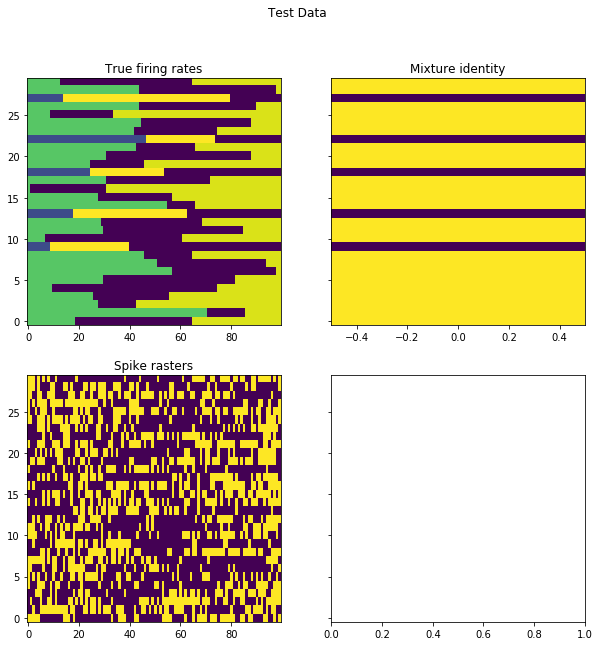

In [18]:
# Visualize test data
fig,ax = plt.subplots(2,2,figsize=(10,10),sharey=True)
ax[0,1].imshow(component_inds[:,np.newaxis], aspect='auto',origin='lower');
ax[0,0].imshow(true_r,aspect='auto',origin='lower');
ax[1,0].imshow(data_vec,aspect='auto',origin='lower');

fig.suptitle('Test Data');
ax[0,0].set_title('True firing rates');
ax[0,1].set_title('Mixture identity');
ax[1,0].set_title('Spike rasters');

In [19]:
# Calculate mean emission values to initialize parameters
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T

## Catergorical Model

In [20]:
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.ones(n_components)*5, shape = n_components)
    
    category = pm.Categorical("category", p=w, shape=trials)
    alphas = pm.HalfCauchy('alphas',5,shape=(n_components,states))
    betas = pm.HalfCauchy('betas',5,shape=(n_components,states))
    
    # Hardcode mixture distributions for now
    clust0_lambda = tt.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = tt.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = tt.stack([clust0_lambda,clust1_lambda])

In [21]:
with model:   
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [22]:
with model:   
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.tag.test_value.shape
    weight_stack = tt.concatenate([np.ones((weight_stack_shape[0],1,weight_stack_shape[-1])),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((weight_stack_shape[0],1,weight_stack_shape[-1]))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [23]:
with model:
    selected_lambdas = lambdas[category][:,:,np.newaxis]

In [24]:
with model:
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)

In [25]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

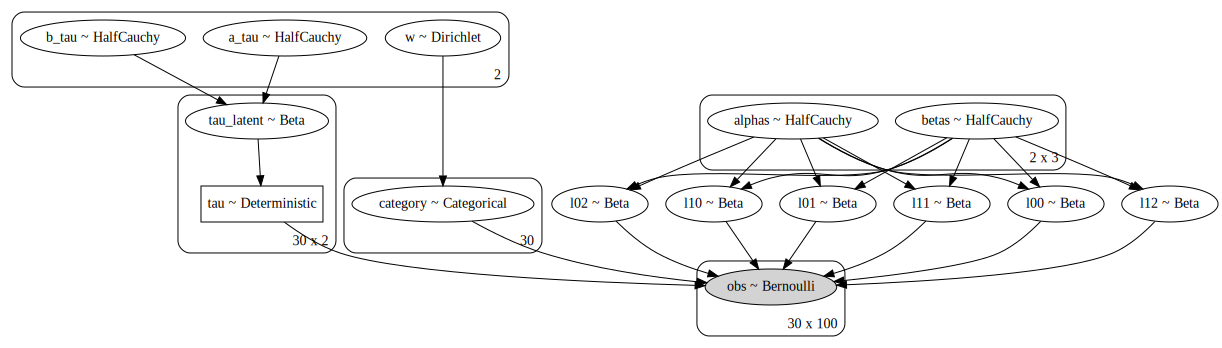

In [26]:
pm.model_to_graphviz(model)

In [27]:
with model:     
    trace = pm.sample()

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

In [28]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:02<00:00, 726.26it/s]


In [29]:
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

In [30]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]

In [31]:
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [41]:
cat_samples = trace['category']
cat_hist = np.array([np.histogram(trial,bins=np.arange(3))[0] for trial in cat_samples.swapaxes(0,1)])
inferred_cat = np.round(1-np.mean(cat_samples,axis=0))
correct_inferred_count = np.sum(component_inds==inferred_cat)

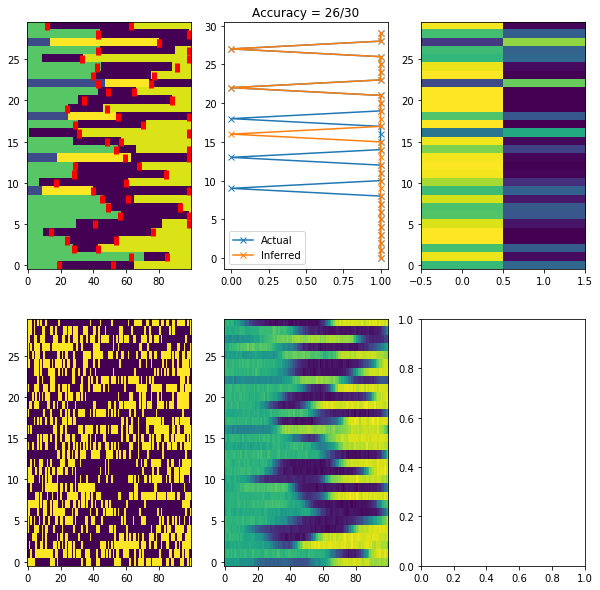

In [43]:
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
ax[0,1].plot(inferred_cat, np.arange(trials),'-x', label='Inferred')
ax[0,1].set_title(f'Accuracy = {correct_inferred_count}/{trials}')
ax[0,1].legend()
for trial,val in enumerate(mode_tau):
    ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='red')
ax[0,0].imshow(true_r,aspect='auto',origin='lower')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower');
ax[0,2].imshow(cat_hist,aspect='auto',origin='lower');

## Marginalized Model

Sampling would be more efficient if we can use NUTS for all variables.
This can be accomplished by marginalizing out the categorical variables
and using the weights from the Dirichlet distribution to directly weigh
each mixture component for each trial

In [44]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (trials,n_components))
    
    alphas = pm.HalfCauchy('alphas',5,shape=(2,3))
    betas = pm.HalfCauchy('betas',5,shape=(2,3))
    clust0_lambda = tt.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = tt.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = tt.stack([clust0_lambda,clust1_lambda])

In [45]:
with model:   
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [46]:
with model:   
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.tag.test_value.shape
    weight_stack = tt.concatenate([np.ones((weight_stack_shape[0],1,weight_stack_shape[-1])),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((weight_stack_shape[0],1,weight_stack_shape[-1]))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [47]:
with model:
    selected_lambdas = tt.tensordot(w,lambdas,[1,0])[:,:,np.newaxis]
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)

In [48]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

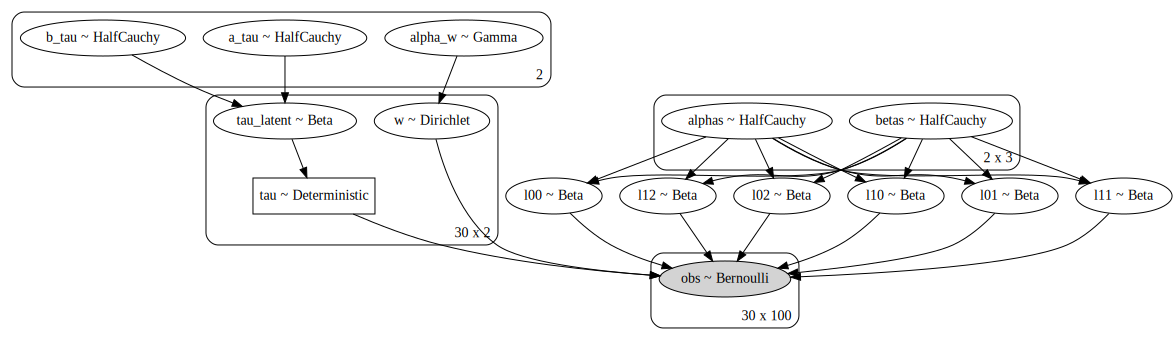

In [49]:
pm.model_to_graphviz(model)

In [50]:
with model:     
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, l12, l11, l10, l02, l01, l00, betas,

In [52]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

100%|██████████| 2000/2000 [00:04<00:00, 449.06it/s]


In [54]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [55]:
w_samples = trace['w']
w_samples_long = np.reshape(w_samples,(-1,w_samples.shape[-1]))
mean_w = np.mean(w_samples,axis=0)
categorical_w = np.argmax(mean_w,axis=-1)

In [56]:
cat_accuracy_list = [np.sum(categorical_w==component_inds),
                      np.sum((1-categorical_w)==component_inds)]
model_ind = np.int(np.argmax(cat_accuracy_list))
cat_accuracy = cat_accuracy_list[model_ind]

hist_out = np.histogram2d(*w_samples_long.T,bins=50)
diag_vals = np.diag(np.flip(hist_out[0],axis=-1))

components_hist = np.histogram(component_inds,np.arange(3))[0]
components_hist = components_hist/np.max(components_hist)

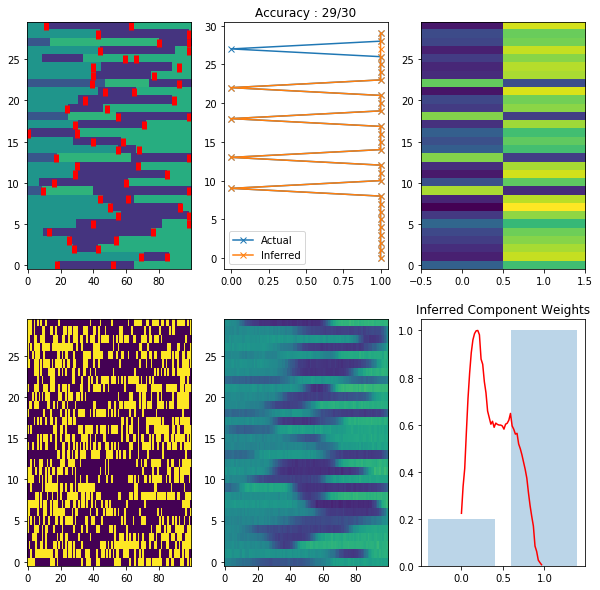

In [58]:
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,0].imshow(true_r,aspect='auto',origin='lower',vmin=0,vmax=1)
ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
ax[0,1].plot(categorical_w, np.arange(trials),'-x', label='Inferred')
ax[0,1].set_title(f'Accuracy : {cat_accuracy}/{categorical_w.shape[0]}')
ax[0,1].legend()
for trial,val in enumerate(mode_tau):
    ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='red')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower',vmin=0,vmax=1);
ax[0,2].imshow(mean_w,aspect='auto',origin='lower');
ax[1,2].plot(hist_out[1][:-1],diag_vals/np.max(diag_vals),c='r');
ax[1,2].bar([0,1],components_hist, alpha = 0.3);
ax[1,2].set_title('Inferred Component Weights');